In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics
import seaborn as sns

In [2]:
df_2020 = pd.read_csv("Spring2020_Merged_goodRuns_nudgesDefined.csv")
df_2023 = pd.read_csv("Spring2023_Merged_goodRuns_nudgesDefined.csv")
df_2025 = pd.read_csv("Spring2025_Merged_goodRuns_nudgesDefined.csv")

/scratch/gjwei/ipykernel_1022016/1037148710.py:1: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv("Spring2020_Merged_goodRuns_nudgesDefined.csv")
/scratch/gjwei/ipykernel_1022016/1037148710.py:2: DtypeWarning: Columns (33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("Spring2023_Merged_goodRuns_nudgesDefined.csv")
/scratch/gjwei/ipykernel_1022016/1037148710.py:3: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv("Spring2025_Merged_goodRuns_nudgesDefined.csv")


In [3]:
# select runs with multiple nudges. Not removing runs with backlash, but manually go through to make sure nudges are monotonic. Some 45/135 runs are flagged as backlash, when it seems like there isn't any
def select_data(df_in):
    df_out = df_in[(df_in['goodRun'])&(df_in['RunHasNudge'])&(df_in['TotalNudges_thisRun']>=1)]
    return df_out

In [4]:
df_2020_good = select_data(df_2020)
df_2023_good = select_data(df_2023)
df_2025_good = select_data(df_2025)

In [5]:
# start and end times are for measuring energy, trim_start_end actually modifies the time axes
def if_backlash_exist(df_in, runNumber, start_times=[], end_times=[],y_lims = []):

    print("select run ",runNumber)

    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600
    roll_0_90 = -10.5
    roll_45_135 = 34.5

    if (runNumber>80000) and (runNumber < 130000):
        minE = 8520
        maxE = 8720
        expectedE = 8620
    elif runNumber>130000:
        minE = 8800
        maxE = 9000
        expectedE = 8900

    df_run = df_in[df_in['RunNumber']==runNumber]

    # should plot backlash nudges too, so we know if we are near one
    df_run_nudges = df_run[(df_run['NudgeOccurred'])]
    nudge_list = df_run_nudges['NudgeNumber'].unique()


    backlash_happen = False

    for seq in nudge_list:

        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        nudge_time = df_this_nudge['TimeStamp'].min()
        nudge_effectiveness = df_this_nudge['NudgeEffectiveness'].mode()[0]
        nudge_effectiveness_pitch = df_this_nudge['NudgeEffectivenessPitch'].mode()[0]
        nudge_effectiveness_yaw = df_this_nudge['NudgeEffectivenessYaw'].mode()[0]

        
        current_pitchDiff = max(df_this_nudge['NudgePitchSize'].unique(), key=abs)  
        current_yawDiff = max(df_this_nudge['NudgeYawSize'].unique(), key=abs)

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>0.5 or abs(current_yawDiff)>0.5:
            # print(df_this_nudge)
            continue
            

        if abs(nudge_effectiveness_pitch)<0.8:
            print("pitch effectiveness: ", nudge_effectiveness_pitch)
            backlash_happen = True
            break

        if abs(nudge_effectiveness_yaw)<0.8:
            print("yaw effectiveness: ", nudge_effectiveness_yaw)
            backlash_happen = True
            break
    
    return backlash_happen

In [6]:
run_numbers_2020 = df_2020_good['RunNumber'].unique()
run2020_without_backlash = []
for run in run_numbers_2020:
    if not if_backlash_exist(df_2020_good, run):
        run2020_without_backlash.append(run)


run_numbers_2023 = df_2023_good['RunNumber'].unique()
run2023_without_backlash = []
for run in run_numbers_2023:
    if not if_backlash_exist(df_2023_good, run):
        run2023_without_backlash.append(run)

run_numbers_2025 = df_2025_good['RunNumber'].unique()
run2025_without_backlash = []
for run in run_numbers_2025:
    if not if_backlash_exist(df_2025_good, run):
        run2025_without_backlash.append(run)

select run  72102
pitch effectiveness:  0.0
select run  72105
select run  72107
pitch effectiveness:  0.0
select run  72109
pitch effectiveness:  -0.7
select run  72112
pitch effectiveness:  0.0
select run  72116
select run  72119
pitch effectiveness:  0.0
select run  72127
pitch effectiveness:  0.0
select run  72130
select run  72133
pitch effectiveness:  0.0
select run  72138
pitch effectiveness:  0.0
select run  72142
select run  72145
pitch effectiveness:  0.0
select run  72158
select run  72160
pitch effectiveness:  0.7
select run  72173
select run  72176
pitch effectiveness:  0.7
select run  72178
pitch effectiveness:  0.0
select run  72179
pitch effectiveness:  0.0
select run  72190
select run  72246
select run  72251
pitch effectiveness:  0.0
select run  72257
pitch effectiveness:  0.0
select run  72258
pitch effectiveness:  0.0
select run  72260
pitch effectiveness:  0.0
select run  72264
select run  72265
pitch effectiveness:  0.0
select run  72266
select run  72273
pitch eff

In [7]:
# plot energy vs time for all nudges that arent backlash 
# subplot has size of change in pitch/yaw

# start and end times are for measuring energy, trim_start_end actually modifies the time axes
def plot_run(df_in, runNumber, start_times=[], end_times=[],trim_start_end=[],y_lims = []):

    print("plotting for run ",runNumber)

    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600
    roll_0_90 = -10.5
    roll_45_135 = 34.5

    if (runNumber>80000) and (runNumber < 130000):
        minE = 8520
        maxE = 8720
        expectedE = 8620
    elif runNumber>130000:
        minE = 8800
        maxE = 9000
        expectedE = 8900

    df_run = df_in[df_in['RunNumber']==runNumber]
    if len(trim_start_end)!=0:
        df_run = df_run[(df_run['TimeStamp']>=trim_start_end[0])&(df_run['TimeStamp']<=trim_start_end[1])]

    # should plot backlash nudges too, so we know if we are near one
    df_run_nudges = df_run[(df_run['NudgeOccurred'])]
    nudge_list = df_run_nudges['NudgeNumber'].unique()


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(6,8),sharex=True)
    #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,sharex=True)


    set_energy_drawn = False
    nudge_label_set = False

    nudge_times = []
    pitchDiffs = []
    yawDiffs = []

    first_nudge_time = -1000
    max_nudge_time = 0

    print("Total number of nudges this run is ",df_run['TotalNudges_thisRun'].unique())
    print("Nudge list is ",nudge_list)
    print("Nudge has backlash count",df_run['BacklashNudge'].value_counts())
    print("Nudge occurred value counts: ",df_run['NudgeOccurred'].value_counts())
    
    for seq in nudge_list:

        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        nudge_time = df_this_nudge['TimeStamp'].min()
        nudge_effectiveness = df_this_nudge['NudgeEffectiveness'].mode()[0]

        is_backlash = df_this_nudge['BacklashNudge'].mode()[0]

        print('Nudge number',seq,'occurs at time',nudge_time,'and has nudge effectiveness of',nudge_effectiveness)

        if first_nudge_time==-1000:
            first_nudge_time = nudge_time

        current_pitchDiff = df_this_nudge['NudgePitchSize'].unique()[0]    
        current_yawDiff = df_this_nudge['NudgeYawSize'].unique()[0]

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>1 or abs(current_yawDiff)>1:
            #print(df_this_nudge)
            continue

        pitchDiffs.append(current_pitchDiff)
        yawDiffs.append(current_yawDiff)
        nudge_times.append(nudge_time)
            
        if nudge_time>max_nudge_time:
            max_nudge_time = nudge_time

        # plot the nudge with a vertical red line, add label if label not set yet
        if is_backlash:
            ax1.axvline(nudge_time,color='gray',linestyle='--',alpha=0.5)
        elif not nudge_label_set:
            ax1.axvline(nudge_time,color='r',linestyle='--',label='Nudge')
            nudge_label_set = True
        else:
            ax1.axvline(nudge_time,color='r',linestyle='--')
        
        # draw the desired energy and a green shaded +/- 10 MeV band
        if not set_energy_drawn:
            ax1.axhline(y=expectedE,color='g',linestyle='--',label='Set Energy')
            ax1.axhspan(expectedE-10,expectedE+10,color='g',alpha=0.1)
            set_energy_drawn = True
           
    # get the time when the DAQ turned on (status 2)
    df_daq_on = df_in[(df_in['RunNumber']==runNumber)&(df_in['DAQ:STATUS']==2)]

    # initialize to large value. If daq never turned on, defaults to first nudge time
    daq_on_time = 10000
    set_daq_on_time = False
    if not df_daq_on.empty and len(trim_start_end)==0:
        daq_on_time = df_daq_on['TimeStamp'].min()
        set_daq_on_time = True
        print('daq on at time',daq_on_time)


    ax3.plot(nudge_times,yawDiffs,label='YawDiff',marker='o',color='blue')
    ax3.plot(nudge_times,pitchDiffs,label='PitchDiff',marker='o',color='orange')
    ax3.set_ylabel('Nudge Size (deg.)')
    plt.xlabel("Time Stamp (s)")
    ax3.legend()

    
    if set_daq_on_time:
        ax1.axvline(daq_on_time,color='black',label='DAQ On')

    # want the later of the daq turning on and the last nudge
    end_time = max(daq_on_time,max_nudge_time)
    # want the earliest of the daq turning on and the first nudge
    first_time = min(first_nudge_time,daq_on_time)
    
    df_vis = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']>=(first_time-30))&(df_in['TimeStamp']<=(end_time+30))&(df_in['CBREM:ENERGY']<maxE)&(df_in['CBREM:ENERGY']>minE)]

    if len(trim_start_end)!=0:
            df_vis = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']>=(trim_start_end[0]))&(df_in['TimeStamp']<=(trim_start_end[1]))&(df_in['CBREM:ENERGY']<maxE)&(df_in['CBREM:ENERGY']>minE)]

    ax1.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'],color='b')
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    if len(y_lims)==2:
        ax1.set_ylim(y_lims[0],y_lims[1])

    if len(start_times)==2:
        ax1.axvspan(start_times[0],start_times[1],color='cyan',alpha=0.2)
    if len(end_times)==2:
        ax1.axvspan(end_times[0],end_times[1],color='cyan',alpha=0.2)


    ax2.plot(df_run_nudges['TimeStamp'],df_run_nudges['NudgeEffectiveness'],color='black',marker='o')
    ax2.set_ylabel('Nudge Effectiveness')
    ax2.axhline(1.0,color='black',alpha=0.2,linestyle='--')
    ax2.axhline(0.0,color='black',alpha=0.2,linestyle='--')
    #ax3.yaxis.set_major_locator(ticker.MaxNLocator(4))
    #ax3.set_ylim(0,1)

    ax4.plot(df_vis['TimeStamp'],df_vis['GONI:PITCH'],color='orange',alpha=0.75)
    #ax4.plot(df_vis['TimeStamp'],df_vis['GONI:PITCH.RBV'],color='orange',alpha=0.5,linestyle='--')
    ax4.set_ylabel('Pitch (deg.)')
    ax4.tick_params('y',colors='orange')
    
    ax4b = ax4.twinx()
    ax4b.plot(df_vis['TimeStamp'],df_vis['GONI:YAW'],color='blue',alpha=0.75)
    #ax4b.plot(df_vis['TimeStamp'],df_vis['GONI:YAW.RBV'],color='blue',alpha=0.5,linestyle='--')
    ax4b.set_ylabel('Yaw (deg.)')
    ax4b.tick_params('y',colors='blue')



    
    print("Unique CBREM:PLANE values:",df_vis['CBREM:PLANE'].unique())
    plane_values = df_vis['CBREM:PLANE'].mode()
    roll_values = df_vis['GONI:ROLL'].mode()
    # get radiator name and orientation, strip deg and add plane info
    radiator_val = df_vis['RADIATOR:NAME'].mode()[0]
    if "Undefined" not in radiator_val:
        radiator_val = radiator_val.strip('deg')


    if radiator_val=="Undefined":
        # this indicates a communication issue in EPICS, as Undefined is set in cleanAndConvert for bad values of inputs
        # reset using known roll vals for 0/90 and 45/135
        print("Undefined radiator name is most common, value counts are:")
        print(df_vis['RADIATOR:NAME'].value_counts())
        print("most common roll value is ",roll_values[0])
        
        if roll_values[0]==roll_0_90:
            radiator_val = "0/90" 
        elif roll_values[0]==roll_45_135:
            radiator_val = "45/135"
        print("resetting radiator_val to ",radiator_val)

    if plane_values[0]==1:
        radiator_val+='PARA '
    elif plane_values[0]==2:
        radiator_val+='PERP '

    print("plane_values are",plane_values)
    print('roll_values are',roll_values)
    print('roll values are',df_vis['GONI:ROLL'].value_counts())
    print('roll values are',df_in[df_in['RunNumber']==runNumber]['GONI:ROLL'].value_counts())

    titleStr = 'Run '+str(runNumber)+" "+radiator_val
    
    ax1.set_title(titleStr)

    ax1.set_ylabel("$E_\gamma$ (MeV)")
    #ax1.legend()


    # plt.savefig("plots/multiNudge/plot_run_"+str(runNumber)+".pdf")
    plt.show()

    print("nudge times: ",nudge_times)

<>:196: SyntaxWarning: invalid escape sequence '\g'
<>:196: SyntaxWarning: invalid escape sequence '\g'
/scratch/gjwei/ipykernel_1022016/1812072469.py:196: SyntaxWarning: invalid escape sequence '\g'
  ax1.set_ylabel("$E_\gamma$ (MeV)")


# check actual runs

## spring 2020

In [8]:
run2020_with_backlash = []
for run in run_numbers_2020:
    if run not in run2020_without_backlash:
        run2020_with_backlash.append(run)

print("Runs with backlash in 2020:")
print(run2020_with_backlash)
print("Runs without backlash in 2020:")
print(run2020_without_backlash)

Runs with backlash in 2020:
[72102, 72107, 72109, 72112, 72119, 72127, 72133, 72138, 72145, 72160, 72176, 72178, 72179, 72251, 72257, 72258, 72260, 72265, 72273, 72294, 72297, 72363, 72370, 72388, 72406, 72410, 72420, 72424, 72434, 72653, 72657, 72658, 72659, 72673, 72677, 72678, 72684, 72686, 72708, 72719, 72722, 72730, 72732, 72742, 72745, 72754, 72757, 72761, 72771, 72773, 72780, 72798, 72812, 72814, 72815, 72816, 72824, 72828, 72835, 72837, 72841, 72848, 72852, 72854, 72855, 72859, 72868, 72871, 72882, 72889, 72909, 72916, 72917, 72928, 72930, 73039, 73041, 73045, 73051, 73055, 73058, 73062, 73066, 73067, 73073, 73078, 73088, 73093, 73108, 73121, 73123, 73130, 73147, 73151, 73166, 73167, 73171, 73173, 73175, 73178, 73182, 73188, 73191, 73212, 73214, 73217, 73225, 73227, 73263]
Runs without backlash in 2020:
[72105, 72116, 72130, 72142, 72158, 72173, 72190, 72246, 72264, 72266, 72274, 72283, 72285, 72302, 72367, 72375, 72423, 72650, 72666, 72703, 72707, 72725, 72739, 72749, 72781, 7

### with backlash

plotting for run  72406
Total number of nudges this run is  [3]
Nudge list is  [1 2 3]
Nudge has backlash count BacklashNudge
False    6870
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6870
True        3
Name: count, dtype: int64
Nudge number 1 occurs at time 259.0 and has nudge effectiveness of 0.0
Nudge number 2 occurs at time 286.0 and has nudge effectiveness of 0.0
Nudge number 3 occurs at time 338.0 and has nudge effectiveness of 0.8999999999999999
daq on at time 366.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    166
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6873
Name: count, dtype: int64


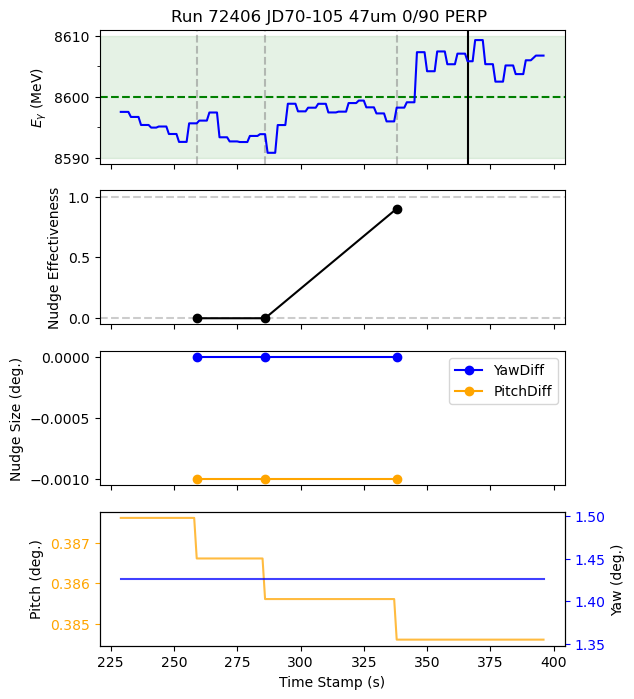

nudge times:  [259.0, 286.0, 338.0]


In [59]:
plot_run(df_2020_good, 72406)

plotting for run  72160
Total number of nudges this run is  [3]
Nudge list is  [1 2 3]
Nudge has backlash count BacklashNudge
False    6772
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6772
True        3
Name: count, dtype: int64
Nudge number 1 occurs at time 548.0 and has nudge effectiveness of 0.7
Nudge number 2 occurs at time 559.0 and has nudge effectiveness of 0.7
Nudge number 3 occurs at time 582.0 and has nudge effectiveness of 0.7
daq on at time 613.0
Unique CBREM:PLANE values: [1]
plane_values are 0    1
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    118
Name: count, dtype: int64
roll values are GONI:ROLL
 34.5    6661
-10.5     114
Name: count, dtype: int64


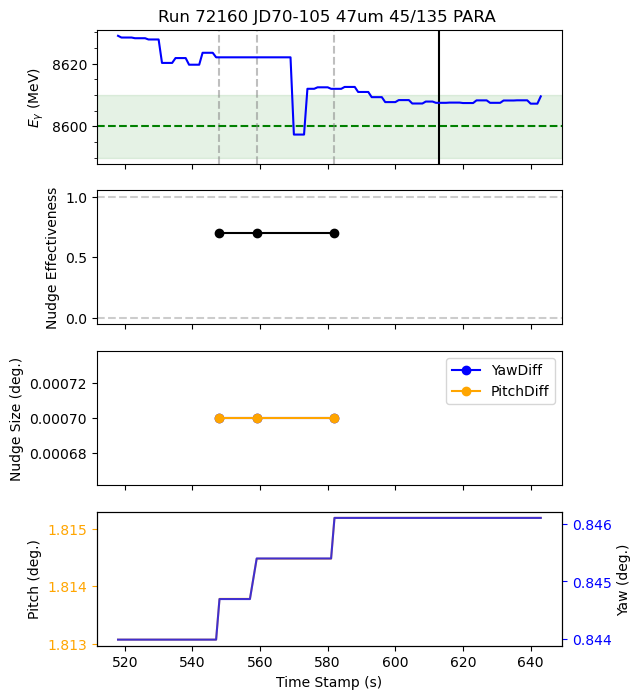

nudge times:  [548.0, 559.0, 582.0]


In [9]:
plot_run(df_2020_good, 72160)

plotting for run  72112
Total number of nudges this run is  [11]
Nudge list is  [ 1  2  3  4  5  6  7  8  9 10 11]
Nudge has backlash count BacklashNudge
False    6683
True        2
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6674
True       11
Name: count, dtype: int64
Nudge number 1 occurs at time 242.0 and has nudge effectiveness of 1.0
Nudge number 2 occurs at time 244.0 and has nudge effectiveness of 1.0
Nudge number 3 occurs at time 250.0 and has nudge effectiveness of 1.0
Nudge number 4 occurs at time 253.0 and has nudge effectiveness of 1.0
Nudge number 5 occurs at time 257.0 and has nudge effectiveness of 1.0
Nudge number 6 occurs at time 261.0 and has nudge effectiveness of 1.0
Nudge number 7 occurs at time 265.0 and has nudge effectiveness of 1.0
Nudge number 8 occurs at time 269.0 and has nudge effectiveness of 1.0
Nudge number 9 occurs at time 273.0 and has nudge effectiveness of 1.0
Nudge number 10 occurs at time 747.0 and has nudge effe

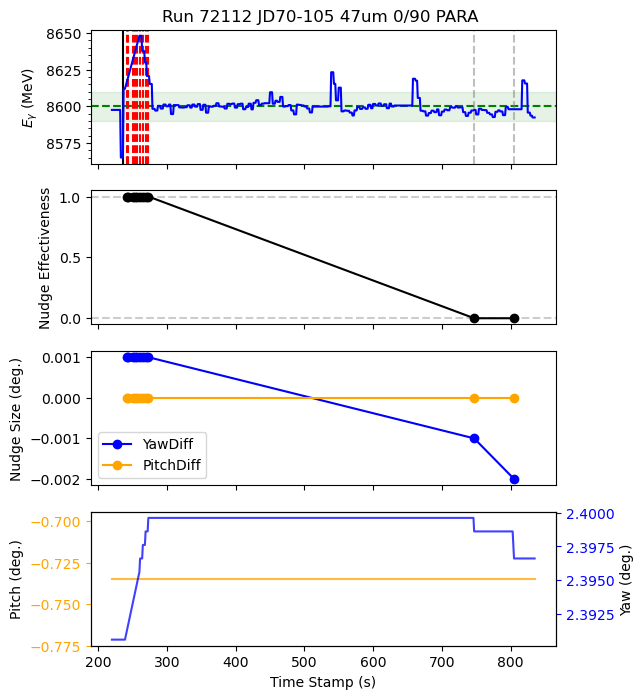

nudge times:  [242.0, 244.0, 250.0, 253.0, 257.0, 261.0, 265.0, 269.0, 273.0, 747.0, 805.0]


In [10]:
plot_run(df_2020_good, 72112)

plotting for run  72127
Total number of nudges this run is  [5]
Nudge list is  [1 2 3 4 5]
Nudge has backlash count BacklashNudge
False    6370
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6368
True        5
Name: count, dtype: int64
Nudge number 1 occurs at time 74.0 and has nudge effectiveness of 1.0
Nudge number 2 occurs at time 81.0 and has nudge effectiveness of 1.0
Nudge number 3 occurs at time 136.0 and has nudge effectiveness of 0.0
Nudge number 4 occurs at time 162.0 and has nudge effectiveness of 0.0
Nudge number 5 occurs at time 180.0 and has nudge effectiveness of 0.8999999999999999
daq on at time 263.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    229
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6373
Name: count, dtype: int64


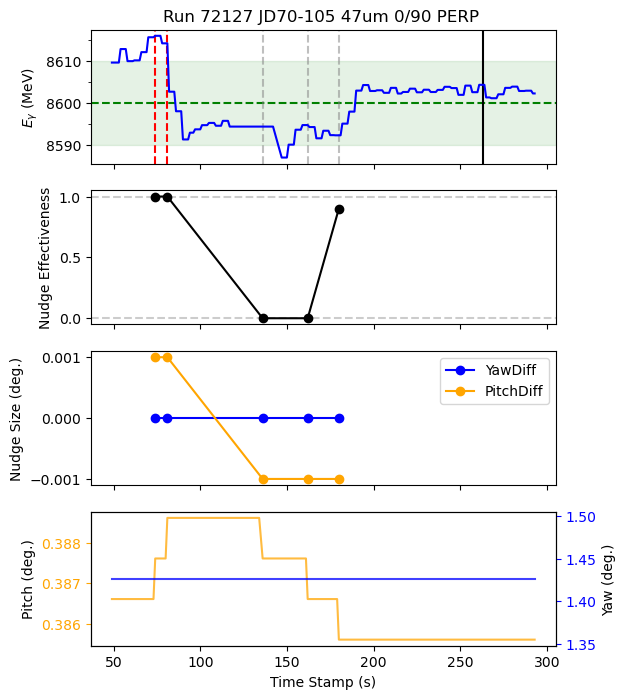

nudge times:  [74.0, 81.0, 136.0, 162.0, 180.0]


In [11]:
plot_run(df_2020_good, 72127)

### without backlash

plotting for run  73230
Total number of nudges this run is  [5]
Nudge list is  [1 2 3 4 5]
Nudge has backlash count BacklashNudge
False    9012
True        1
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    9007
True        6
Name: count, dtype: int64
Nudge number 1 occurs at time 2444.0 and has nudge effectiveness of 7.707788269017254
Nudge number 2 occurs at time 2546.0 and has nudge effectiveness of 1.0
Nudge number 3 occurs at time 2588.0 and has nudge effectiveness of 1.0
Nudge number 4 occurs at time 2622.0 and has nudge effectiveness of 1.0
Nudge number 5 occurs at time 2692.0 and has nudge effectiveness of 1.0
daq on at time 2768.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    34.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
34.5    166
Name: count, dtype: int64
roll values are GONI:ROLL
34.50    7674
29.55    1339
Name: count, dtype: int64


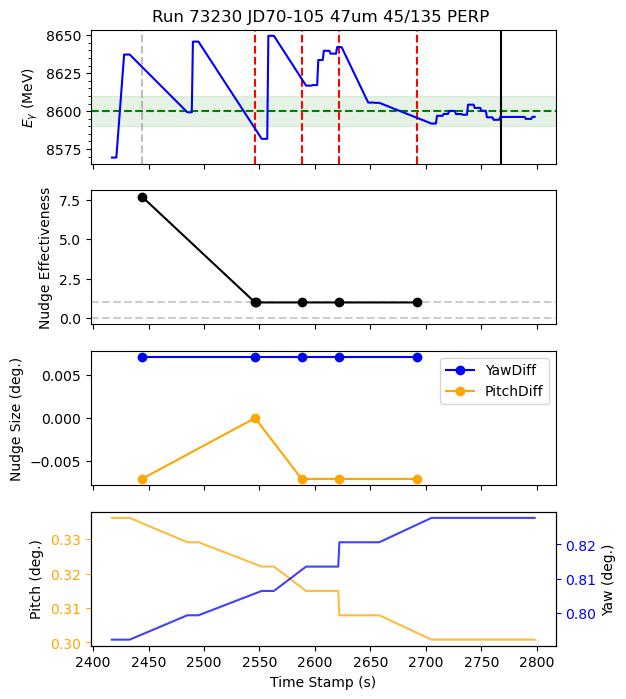

nudge times:  [2444.0, 2546.0, 2588.0, 2622.0, 2692.0]


In [98]:
plot_run(df_2020_good, 73230)

plotting for run  72105
Total number of nudges this run is  [2]
Nudge list is  [1 2]
Nudge has backlash count BacklashNudge
False    6701
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    6699
True        2
Name: count, dtype: int64
Nudge number 1 occurs at time 160.0 and has nudge effectiveness of 1.0
Nudge number 2 occurs at time 192.0 and has nudge effectiveness of 1.0
daq on at time 270.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0   -10.5
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
-10.5    171
Name: count, dtype: int64
roll values are GONI:ROLL
-10.5    6701
Name: count, dtype: int64


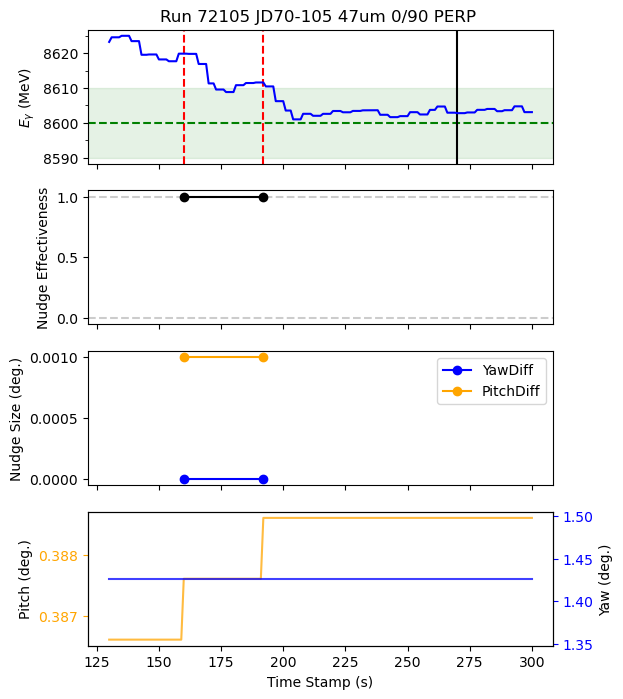

nudge times:  [160.0, 192.0]


In [12]:
plot_run(df_2020_good,72105)

## spring 2023

In [13]:
run2023_with_backlash = []
for run in run_numbers_2023:
    if run not in run2023_without_backlash:
        run2023_with_backlash.append(run)

print("Runs with backlash in 2023:")
print(run2023_with_backlash)
print("Runs without backlash in 2023:")
print(run2023_without_backlash)

Runs with backlash in 2023:
[120313, 120404, 120406, 120420, 120541, 120566, 120710, 120724, 120740, 120753, 120768, 120787, 120821, 120826, 120828, 120834, 120837, 120848, 120850, 120852, 120857, 120886, 120894, 120916, 120930, 120931, 120938, 120941, 120991, 120998, 121006, 121025, 121029, 121051, 121053, 121068, 121084, 121097, 121102, 121132, 121137, 121157, 121160, 121169, 121174, 121185, 121187, 121205]
Runs without backlash in 2023:
[120315, 120322, 120353, 120372, 120398, 120411, 120412, 120437, 120451, 120470, 120536, 120562, 120606, 120643, 120663, 120687, 120722, 120762, 120782, 120784, 120798, 120813, 120817, 120839, 120843, 120885, 120911, 120936, 120989, 121001, 121009, 121036, 121062, 121070, 121086, 121099, 121130, 121143, 121171, 121182, 121183, 121203]


### with backlash

plotting for run  121102
Total number of nudges this run is  [21]
Nudge list is  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Nudge has backlash count BacklashNudge
False    3600
True       12
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3588
True       24
Name: count, dtype: int64
Nudge number 1 occurs at time 4176.0 and has nudge effectiveness of 0.7
Nudge number 2 occurs at time 4193.0 and has nudge effectiveness of 0.0
Nudge number 3 occurs at time 4199.0 and has nudge effectiveness of 0.7
Nudge number 4 occurs at time 4207.0 and has nudge effectiveness of 1.0
Nudge number 5 occurs at time 4217.0 and has nudge effectiveness of 1.0
Nudge number 6 occurs at time 4221.0 and has nudge effectiveness of 3.0
Nudge number 7 occurs at time 4441.0 and has nudge effectiveness of 1.0
Nudge number 8 occurs at time 4452.0 and has nudge effectiveness of 1.0
Nudge number 9 occurs at time 4459.0 and has nudge effectiveness of 1.0
Nudge number 10

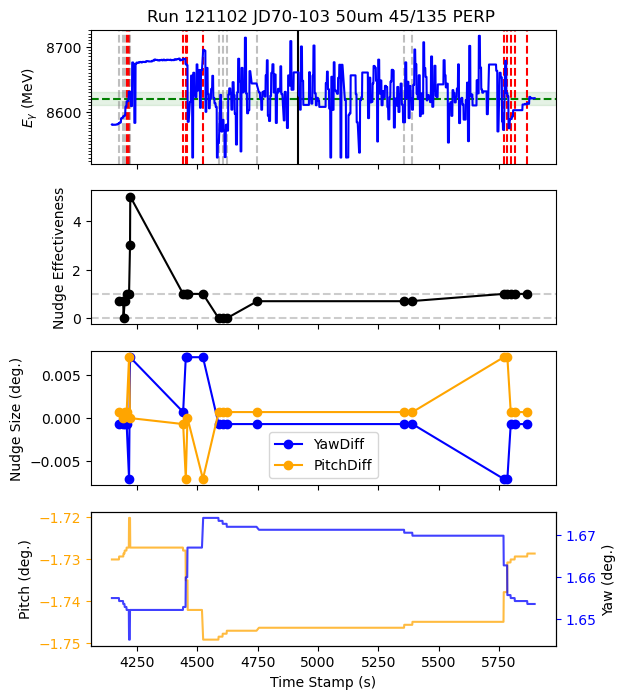

nudge times:  [4176.0, 4193.0, 4199.0, 4207.0, 4217.0, 4221.0, 4441.0, 4452.0, 4459.0, 4523.0, 4588.0, 4605.0, 4622.0, 4748.0, 5357.0, 5391.0, 5769.0, 5784.0, 5798.0, 5815.0, 5867.0]


In [44]:
plot_run(df_2023_good, 121102)

plotting for run  120420
Total number of nudges this run is  [5]
Nudge list is  [1 2 3 4 5]
Nudge has backlash count BacklashNudge
False    3147
True        5
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    3147
True        5
Name: count, dtype: int64
Nudge number 1 occurs at time 246.0 and has nudge effectiveness of 0.0
Nudge number 2 occurs at time 373.0 and has nudge effectiveness of 0.0
Nudge number 3 occurs at time 388.0 and has nudge effectiveness of 0.8999999999999999
Nudge number 4 occurs at time 514.0 and has nudge effectiveness of 0.0
Nudge number 5 occurs at time 677.0 and has nudge effectiveness of 0.0
daq on at time 289.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    162.0
Name: GONI:ROLL, dtype: float64
roll values are GONI:ROLL
162.0    485
Name: count, dtype: int64
roll values are GONI:ROLL
162.0    3152
Name: count, dtype: int64


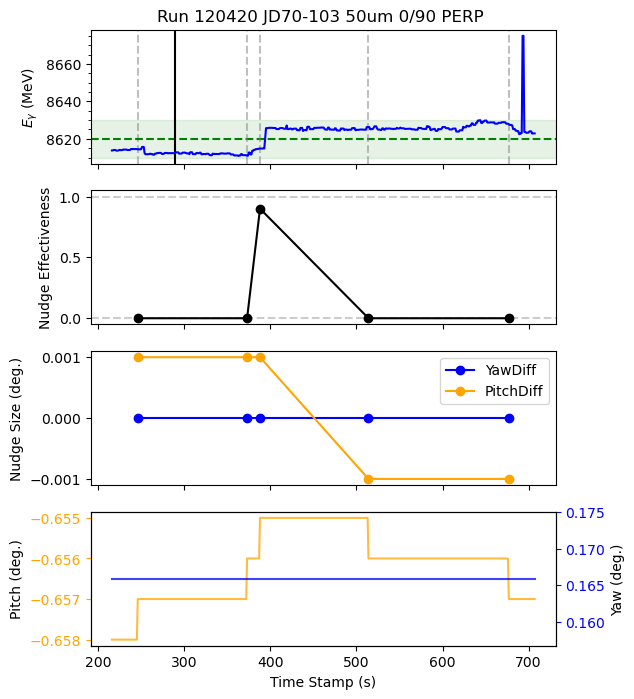

nudge times:  [246.0, 373.0, 388.0, 514.0, 677.0]


In [14]:
plot_run(df_2023_good, 120420)

## Spring 2025

In [15]:
run2025_with_backlash = []
for run in run_numbers_2025:
    if run not in run2025_without_backlash:
        run2025_with_backlash.append(run)

print("Runs with backlash in 2025:")
print(run2025_with_backlash)
print("Runs without backlash in 2025:")
print(run2025_without_backlash)

Runs with backlash in 2025:
[131407, 131409, 131416, 131422, 131429, 131438, 131443, 131447, 131488, 131491, 131600, 131620, 131622, 131634, 131658, 131662, 131672, 131703, 131706, 131709, 131714, 131719, 131720, 131734, 131749, 131751, 131774, 131777, 131807, 131816, 131825, 131840, 131841, 131863, 131881, 131887, 131890, 131894, 131904, 131918, 131921, 131932, 131953, 131964, 131965, 131968, 131974, 131996, 132001, 132003, 132004, 132009, 132010, 132033, 132039, 132049, 132061, 132071, 132088, 132093, 132100, 132111, 132113, 132126, 132127, 132137, 132158]
Runs without backlash in 2025:
[131421, 131456, 131602, 131677, 131726, 131741, 131744, 131745, 131771, 131801, 131819, 131820, 131829, 131866, 131870, 131874, 131891, 131905, 131908, 131925, 131937, 131955, 131956, 131992, 131998, 132006, 132017, 132021, 132024, 132045, 132048, 132052, 132095, 132104, 132108, 132110, 132112, 132132, 132139, 132142, 132145, 132152]


### with backlash

plotting for run  131443
Total number of nudges this run is  [9]
Nudge list is  [1 2 3 4 5 6 7 8 9]
Nudge has backlash count BacklashNudge
False    4452
True        3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    4446
True        9
Name: count, dtype: int64
Nudge number 1 occurs at time 570.0 and has nudge effectiveness of 1.0
Nudge number 2 occurs at time 580.0 and has nudge effectiveness of 1.0
Nudge number 3 occurs at time 592.0 and has nudge effectiveness of 1.0
Nudge number 4 occurs at time 603.0 and has nudge effectiveness of 1.0
Nudge number 5 occurs at time 622.0 and has nudge effectiveness of 1.0
Nudge number 6 occurs at time 652.0 and has nudge effectiveness of 1.0
Nudge number 7 occurs at time 683.0 and has nudge effectiveness of 0.0
Nudge number 8 occurs at time 708.0 and has nudge effectiveness of 0.0
Nudge number 9 occurs at time 728.0 and has nudge effectiveness of 0.8999999999999999
daq on at time 858.0
Unique CBREM:PLANE values: [2]
pla

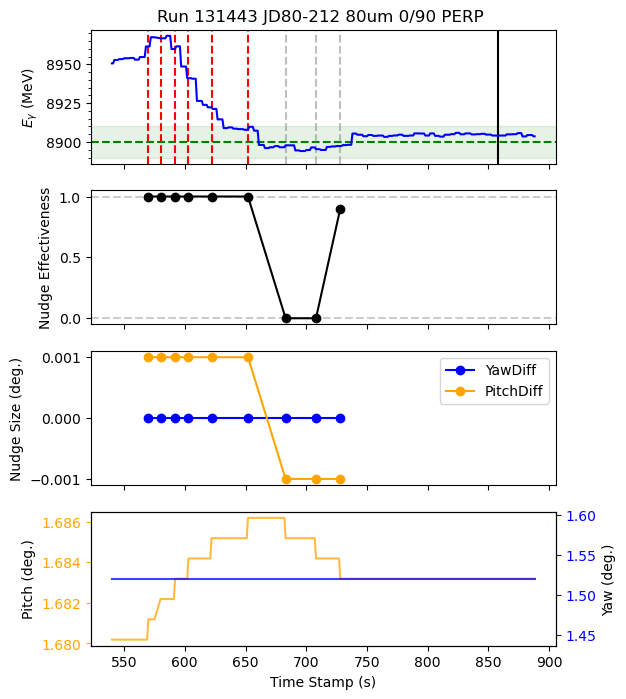

nudge times:  [570.0, 580.0, 592.0, 603.0, 622.0, 652.0, 683.0, 708.0, 728.0]


In [22]:
plot_run(df_2025_good, 131443)

plotting for run  131438
Total number of nudges this run is  [13]
Nudge list is  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
Nudge has backlash count BacklashNudge
False    809
True       3
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    799
True      13
Name: count, dtype: int64
Nudge number 1 occurs at time 841.0 and has nudge effectiveness of 1.0
Nudge number 2 occurs at time 850.0 and has nudge effectiveness of 1.0
Nudge number 3 occurs at time 855.0 and has nudge effectiveness of 1.0
Nudge number 4 occurs at time 862.0 and has nudge effectiveness of 1.0
Nudge number 5 occurs at time 903.0 and has nudge effectiveness of 1.0
Nudge number 6 occurs at time 920.0 and has nudge effectiveness of 0.0
Nudge number 7 occurs at time 939.0 and has nudge effectiveness of 0.0
Nudge number 8 occurs at time 948.0 and has nudge effectiveness of 0.9000000000000004
Nudge number 9 occurs at time 957.0 and has nudge effectiveness of 1.0
Nudge number 10 occurs at time 1019.0

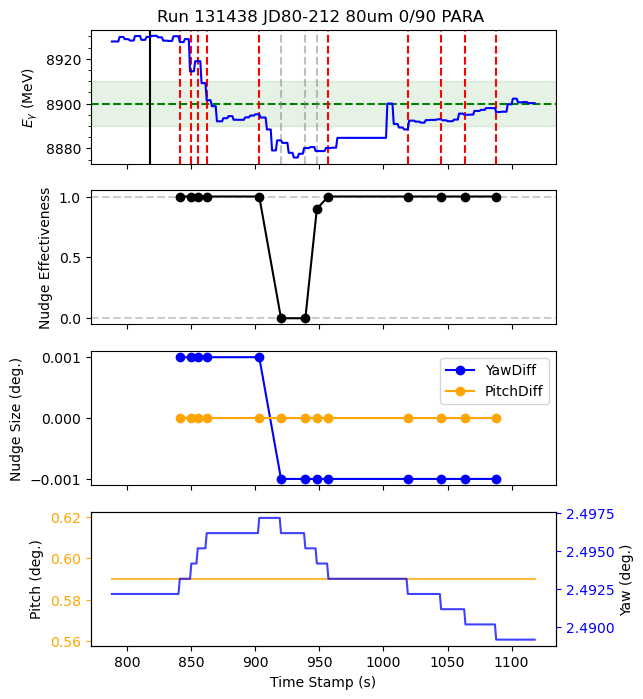

nudge times:  [841.0, 850.0, 855.0, 862.0, 903.0, 920.0, 939.0, 948.0, 957.0, 1019.0, 1045.0, 1064.0, 1088.0]


In [21]:
plot_run(df_2025_good, 131438)

plotting for run  131429
Total number of nudges this run is  [8]
Nudge list is  [1 2 3 4 5 6 7 8]
Nudge has backlash count BacklashNudge
False    5926
True        4
Name: count, dtype: int64
Nudge occurred value counts:  NudgeOccurred
False    5921
True        9
Name: count, dtype: int64
Nudge number 1 occurs at time 201.0 and has nudge effectiveness of 1.0
Nudge number 2 occurs at time 219.0 and has nudge effectiveness of 1.0
Nudge number 3 occurs at time 237.0 and has nudge effectiveness of 1.0
Nudge number 4 occurs at time 243.0 and has nudge effectiveness of 1.0
Nudge number 5 occurs at time 266.0 and has nudge effectiveness of 1.0
Nudge number 6 occurs at time 288.0 and has nudge effectiveness of 0.0
Nudge number 7 occurs at time 315.0 and has nudge effectiveness of 0.0
Nudge number 8 occurs at time 421.0 and has nudge effectiveness of 0.0
daq on at time 620.0
Unique CBREM:PLANE values: [2]
plane_values are 0    2
Name: CBREM:PLANE, dtype: int64
roll_values are 0    28.4
Name: GON

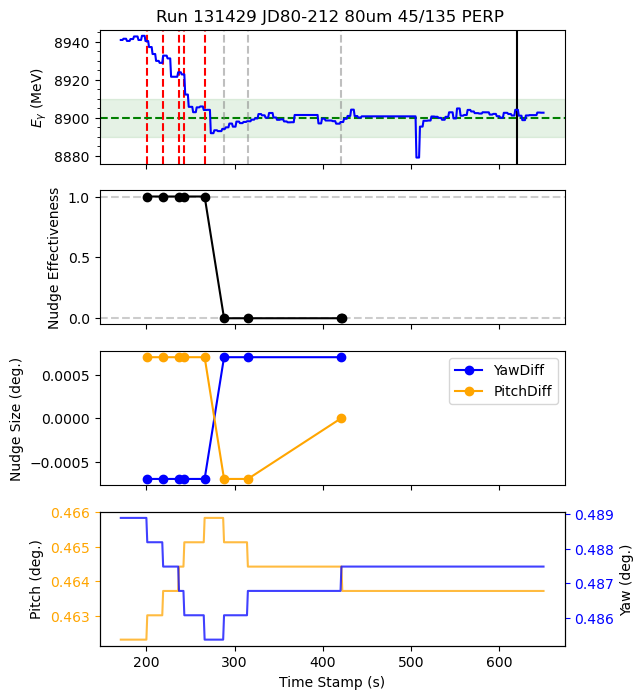

nudge times:  [201.0, 219.0, 237.0, 243.0, 266.0, 288.0, 315.0, 421.0]


In [20]:
plot_run(df_2025_good, 131429)